# Image Segmentation of Handwritten Digits
Build a mdoel that oresicts the segmentation msaks(pixel-wise label map) of handwritten digits. This model will be trained on [M2NIST dataset](https://www.kaggle.com/farhanhubble/multimnistm2nist), a multi digit MNIST.
build a Convolutional Neural Network (CNN) from scratch for the downsampling path and use a Fully Convolutional Network, FCN-8, to upsample and produce the pixel-wise label map. The model will be evaluated using the intersection over union (IOU) and Dice Score.

---



In [3]:
import tensorflow as tf
import os
import zipfile

import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

# Download the Dataset
[M2NIST](https://www.kaggle.com/farhanhubble/multimnistm2nist) is a **multi digit** [MNIST](http://yann.lecun.com/exdb/mnist/).
Each image has up to 3 digits from MNIST digits and the corresponding labels file has the segmentation masks.

The dataset is available on [Kaggle](https://www.kaggle.com) and you can find it [here](https://www.kaggle.com/farhanhubble/multimnistm2nist)


In [4]:
# download the zipped dataset
!wget --no-check-certificate \
       https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip \
       -O /tmp/m2nist.zip

# find and extract to a local folder ( '/tmp/training')
local_zip = '/tmp/m2nist.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

--2023-11-05 18:36:30--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.250.4.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  14.7MB/s    in 1.1s    

2023-11-05 18:36:31 (14.7 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



## Load and Preprocess the Dataset

This dataset can be easily preprocessed since it is available as **Numpy Array Files (.npy)**

1. **combined.npy** has the image files containing the multiple MNIST digits. Each image is of size **64 x 84** (height x width, in pixels).

2. **segmented.npy** has the corresponding segmentation masks. Each segmentation mask is also of size **64 x 84**.

This dataset has **5000** samples and you can make appropriate training, validation, and test splits as required for the problem.

With that, let's define a few utility functions for loading and preprocessing the dataset.

In [5]:
BATCH_SIZE = 32

# casts the image and annotation to their expected data type and normalize
# the input image so that each pixel is inthe raneg [-1,1]
def read_image_and_annotation(image, annotation):
  image = tf.cast(image, dtype=tf.float32)
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  image = image / 127.5
  image -= 1

  return image, annotation

# prepare shuffle batches of training set
def get_training_dataset(images, annos):
  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  training_dataset = training_dataset.map(read_image_and_annotation)

  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset

# prepare batches for validation set
def get_validation_dataset(images, annos):
  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset

# prepare batches for test images
def get_test_dataset(images, annos):
  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  test_dataset = test_dataset.map(read_image_and_annotation)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset

# loads images and segments as numpy arrays from npy files and
# make splits for training, validation andtest datasets.
def load_images_and_segments():

  #Loads images and segmentation masks.
  images = np.load('/tmp/training/combined.npy')
  segments = np.load('/tmp/training/segmented.npy')

  #Makes training, validation, test splits from loaded images and segmentation masks.
  train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
  val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)

  return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)


In [6]:
# Load Dataset
train_slices, val_slices, test_slices = load_images_and_segments()

# Create training, validation, test datasets.
training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

In [7]:
# visualization utility

n_classes = 11 # there are 11 classes in the dataset: one class for each digit (0 to 9) plus the background class

# assign a random color at each class
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

# create an blank image and paste input images
def fuse_with_pil(images):
  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]

  return new_im

# convert a 2D annotaiton to a numpy array with shape (height, width, 3) where the third
# axis represents the color channel.
# the label values are mltiplied by 255 and placed in this axis to give color to annotation
def give_color_to_annotation(annotation):
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')

  for c in range(n_classes):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)

  return seg_img

# Display the image with the grounf=d truth and predicted label maps. and also overlays the metrics
def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)

# display the image and its annotation side by side
def show_annotation_and_image(image, annotation):
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]

  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


# display lists and its annotation side by side
def list_show_annotation(dataset, num_images):
  ds = dataset.unbatch()

  plt.figure(figsize=(20, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())

<ipython-input-7-23b9caab602a>:93: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


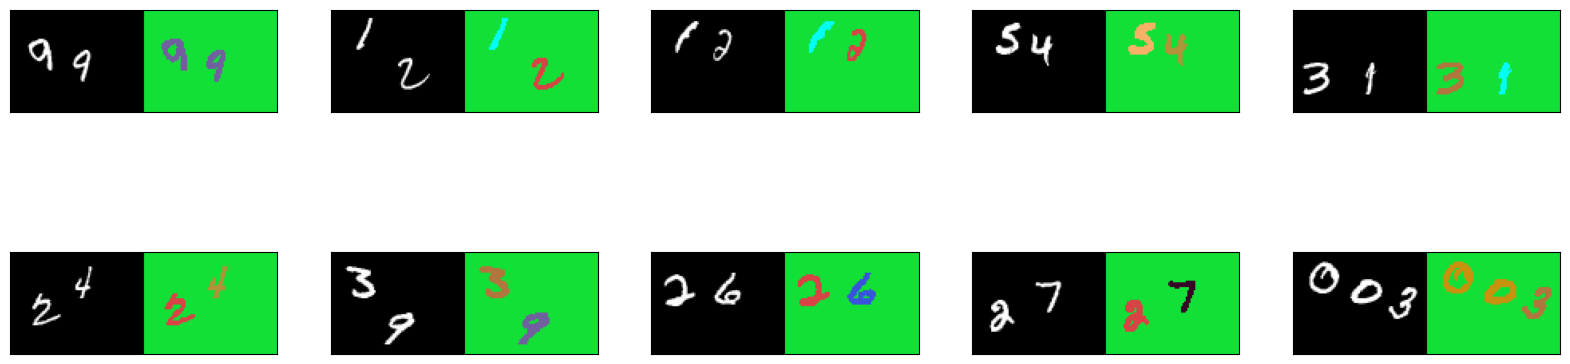

In [8]:
# get 10 images from the training set
list_show_annotation(training_dataset, 10)

<ipython-input-7-23b9caab602a>:93: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


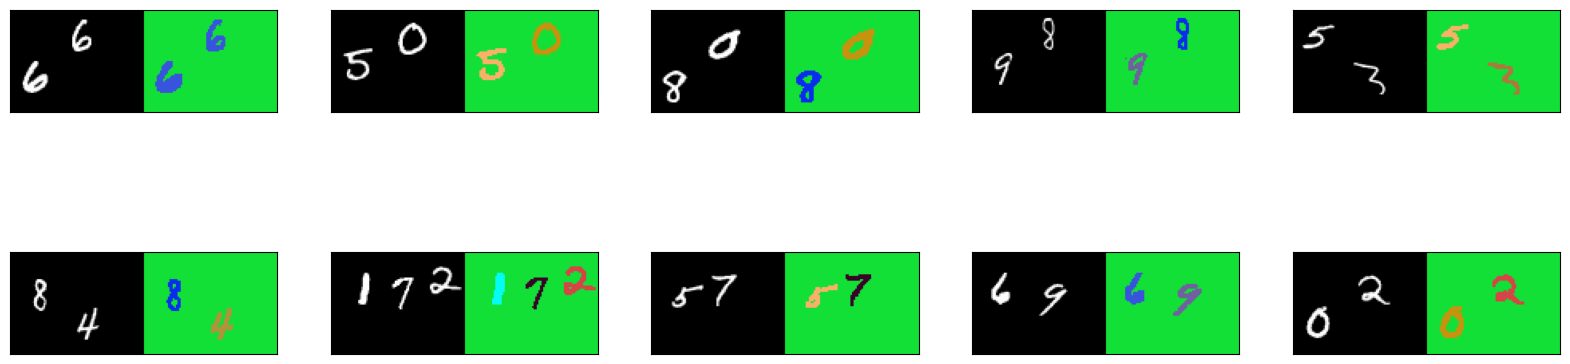

In [9]:
# get 10 images from the validation set
list_show_annotation(validation_dataset, 10)

# Define the model
The image segmentation model will have two paths:

1. **Downsampling Path** - This part of the network extracts the features in the image. This is done through a series of convolution and pooling layers. The final output is a reduced image (because of the pooling layers) with the extracted features. You will build a custom CNN from scratch for this path.

2. **Upsampling Path** - This takes the output of the downsampling path and generates the predictions while also converting the image back to its original size. You will use an FCN-8 decoder for this path.

 The function below is to build the basic convolution block for our CNN. This will have two [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layers each followed by a [LeakyReLU](https://keras.io/api/layers/activation_layers/leaky_relu/), then [max pooled](https://keras.io/api/layers/pooling_layers/max_pooling2d/) and [batch-normalized](https://keras.io/api/layers/normalization_layers/batch_normalization/). Use the functional syntax to stack these layers.

$$Input -> Conv2D -> LeakyReLU -> Conv2D -> LeakyReLU -> MaxPooling2D -> BatchNormalization$$

In [10]:
# parameters describing where the channel dimension is found in our dataset
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, kernel_size, pooling_size, pool_strides):
  x = tf.keras.layers.Conv2D(filters,kernel_size,padding='same',data_format=IMAGE_ORDERING)(input)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Conv2D(filters,kernel_size,padding='same',data_format=IMAGE_ORDERING)(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=pooling_size,strides=pool_strides)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  return x

# Defining the Downsampling Path


In [14]:
# defines the downsampling path of the image segmentation model.

def FCN8(input_height=64, input_width=84):
    img_input = tf.keras.layers.Input(shape=(input_height, input_width, 1))

    # pad the input image width to 96 pixels
    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96-input_width)))(img_input)

    # Block 1
    x = conv_block(x, 32, kernel_size=(3,3), pooling_size=(2,2), pool_strides=(2,2))

    # Block 2
    x = conv_block(x, 64, kernel_size=(3,3), pooling_size=(2,2), pool_strides=(2,2))

    # Block 3
    x = conv_block(x, 128, kernel_size=(3,3), pooling_size=(2,2), pool_strides=(2,2))
    # save the feature map at this stage
    f3 = x

    # Block 4
    x = conv_block(x, 256, kernel_size=(3,3), pooling_size=(2,2), pool_strides=(2,2))
    # save the feature map at this stage
    f4 = x

    # Block 5
    x = conv_block(x, 256, kernel_size=(3,3), pooling_size=(2,2), pool_strides=(2,2))
    # save the feature map at this stage
    f5 = x

    return (f3,f4,f5), img_input

# Define FCN-8 Decoder
Here is the Architecture Diagram
<img src='https://drive.google.com/uc?export=view&id=1lrqB4YegV8jXWNfyYAaeuFlwXIc54aRP' alt='fcn-8'>

In [15]:
from numpy.random.mtrand import f
def fcn8_decoder(convs, n_classes):
  f3, f4, f5 = convs

  # number of filters
  n = 512

  # add convolutional layers on top of the CNN extractor
  o = tf.keras.layers.Conv2D(n, (7,7), activation='relu', padding='same', name='conv6',data_format=IMAGE_ORDERING)(f5)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n, (1,1), activation='relu', padding='same', name='conv7', data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n_classes, (1,1), activation='relu', padding='same', data_format=IMAGE_ORDERING )(o)

  # Upsample o above and crop any extra pixels introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshae it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # updsample the resulting tensor of the operation above
  o = (tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = (tf.keras.layers.Conv2D(n_classes, (1,1), activation='relu', padding='same', data_format=IMAGE_ORDERING))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o,o2])

  # upsmaple up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(o)
  # append a sigmoid activation
  o = (tf.keras.layers.Activation('sigmoid'))(o)

  return o


Combining the downsampling and upsampling paths

In [16]:
# start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# pass the convolutions obtained in the encoder to the decoder
dec_op = fcn8_decoder(convs, n_classes)

# define the model specifying the input (batch of images) and output (decoder output)
model = tf.keras.Model(inputs = img_input, outputs = dec_op)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 84, 1)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 64, 96, 1)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 64, 96, 32)           320       ['zero_padding2d[0][0]']      
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 96, 32)           0         ['conv2d[0][0]']          

In [18]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


# Model Training


In [19]:

### START CODE HERE ###
EPOCHS = 10
### END CODE HERE ###

steps_per_epoch = 4000//BATCH_SIZE
validation_steps = 800//BATCH_SIZE
test_steps = 200//BATCH_SIZE


history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/10
125/125 [==============================] - 22s 40ms/step - loss: 0.1266 - accuracy: 0.8695 - val_loss: 0.0940 - val_accuracy: 0.9416
Epoch 2/10
125/125 [==============================] - 4s 32ms/step - loss: 0.0324 - accuracy: 0.9426 - val_loss: 0.0698 - val_accuracy: 0.9416
Epoch 3/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0292 - accuracy: 0.9427 - val_loss: 0.0464 - val_accuracy: 0.9416
Epoch 4/10
125/125 [==============================] - 6s 50ms/step - loss: 0.0269 - accuracy: 0.9429 - val_loss: 0.0322 - val_accuracy: 0.9417
Epoch 5/10
125/125 [==============================] - 5s 41ms/step - loss: 0.0253 - accuracy: 0.9434 - val_loss: 0.0261 - val_accuracy: 0.9427
Epoch 6/10
125/125 [==============================] - 5s 39ms/step - loss: 0.0243 - accuracy: 0.9440 - val_loss: 0.0262 - val_accuracy: 0.9428
Epoch 7/10
125/125 [==============================] - 4s 32ms/step - loss: 0.0233 - accuracy: 0.9452 - val_loss: 0.0233 - val_accuracy: 0.945

# Model Evaluation
make predicitons

In [21]:
results = model.predict(test_dataset, steps=test_steps)
print(results.shape)

6/6 [==============================] - 0s 11ms/step
(192, 64, 84, 11)


the resulting shape is `(192, 64, 84, 11)`. This means that for each of the 192 images that we have in our test set, there are 11 predictions generated (i.e. one for each class: 0 to 1 plus background).

Thus, lets see the *probability* of the upper leftmost pixel of the 1st image belonging to class 0,




In [22]:
print(results[0,0,0,0])
print(results[0,0,0,10])

0.002571503
0.98647505


What we're interested in is to get the *index* of the highest probability of each of these 11 slices and combine them in a single image. We can do that by getting the [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) at this axis.

In [23]:
results = np.argmax(results, axis=3)

print(results.shape)

(192, 64, 84)


The new array generated per image now only specifies the indices of the class with the highest probability. Let's see the output class of the upper most left pixel. As you might have observed earlier when you inspected the dataset, the upper left corner is usually just part of the background (class 10). The actual digits are written somewhere in the middle parts of the image.

In [24]:
print(results[0,0,0])

# prediction map for image 0
print(results[0,:,:])


10
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


### Metrics

The *intersection over union (IOU)* and the *dice score*. Recall that:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

A small smoothing factor is introduced in the denominators to prevent possible division by zero.

In [25]:
#   Computes the class-wise IOU and Dice Score.

def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

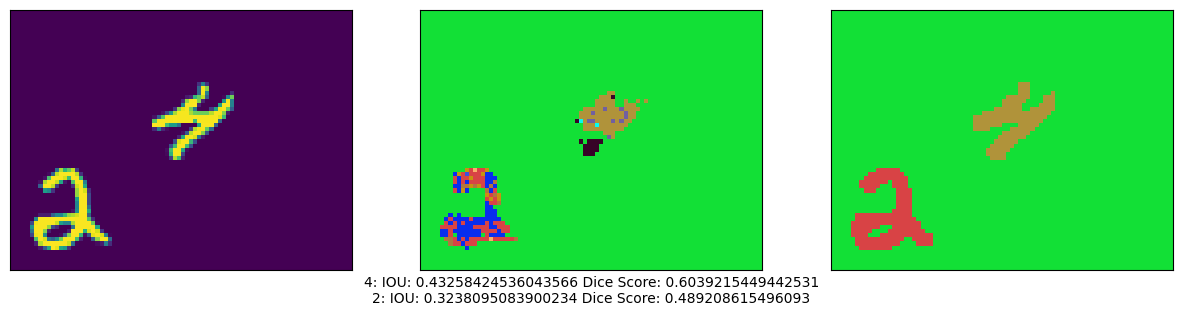

In [26]:
# place a number here between 0 to 191 to pick an image from the test set
integer_slider = 155

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image


iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)


In [27]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score))
  average_iou += iou

Digit 0: IOU: 0.3795381931603702 Dice Score: 0.5502394859991371
Digit 1: IOU: 0.6242764715283002 Dice Score: 0.768682527231231
Digit 2: IOU: 0.22845819454300922 Dice Score: 0.37194296974509006
Digit 3: IOU: 0.3621075301448865 Dice Score: 0.5316871423600005
Digit 4: IOU: 0.32808937491097884 Dice Score: 0.4940772527947835
Digit 5: IOU: 0.06767241369587297 Dice Score: 0.12676624932476618
Digit 6: IOU: 0.23929720336637317 Dice Score: 0.38618210824063287
Digit 7: IOU: 0.43184516690590696 Dice Score: 0.603200928266688
Digit 8: IOU: 0.3964964746886387 Dice Score: 0.5678445765887681
Digit 9: IOU: 0.13365155112501537 Dice Score: 0.23578947339221118
